In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    def ret_true(self,x_series):
        return np.sin(x_series)
    def next_batch(self,batch_size,steps,return_batch_ts = False):
        # Grab a random starting point for each batch
        rand_start = np.random.rand(1,batch_size)
        # Convert to be on time series
        ts_start = rand_start*(self.xmax - self.xmin - (steps*self.resolution))
        # Create batch time series on the x axis
        batch_ts = ts_start + np.arange(0.0,steps+1)*self.resolution
        # Create the Y data for time series
        y_batch = np.sin(batch_ts)
        # Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1),batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)

In [3]:
ts_data = TimeSeriesData(250,0,10)

In [4]:
num_time_steps = 30
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

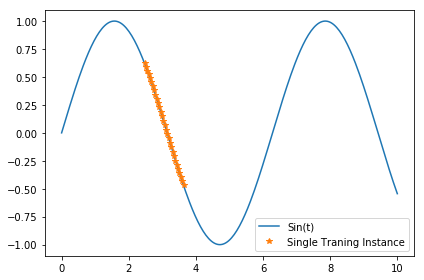

In [5]:
plt.plot(ts_data.x_data,ts_data.y_true,label = 'Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label = 'Single Traning Instance')
plt.legend()
plt.tight_layout()

In [6]:
# training data
train_inst = np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)

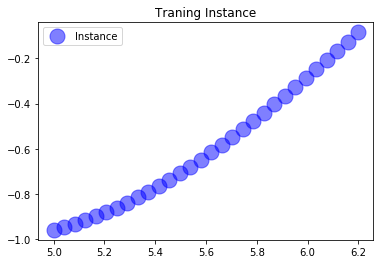

In [7]:
plt.title('Traning Instance')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label = 'Instance')
plt.legend()

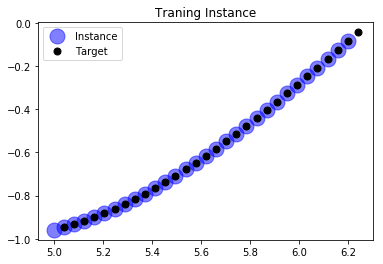

In [8]:
plt.title('Traning Instance')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize=15,alpha=0.5,label = 'Instance')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize = 7,label = 'Target')
plt.legend()

In [9]:
tf.reset_default_graph()

In [15]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iterations = 2000
batch_size = 1

In [13]:
# placeholder
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [16]:
# RNN Cell layer
cell = tf.contrib.rnn.BasicRNNCell(num_units = num_neurons,activation = tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell,output_size=num_outputs)

In [17]:
outputs,states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32)

In [18]:
loss = tf.reduce_mean(tf.square(outputs-y))

In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
X_batch,y_batch = ts_data.next_batch(batch_size,num_time_steps)

In [20]:
with tf.Session() as sess:
    sess.run(init)
    for iteration in range(num_train_iterations):
        X_batch,y_batch = ts_data.next_batch(batch_size,num_time_steps)
        X_batch
        y_batch
        sess.run(train,feed_dict = {X:X_batch,y:y_batch})
        if iteration%100 == 0 :
            mse = loss.eval(feed_dict = {X:X_batch,y:y_batch})
            print (iteration,"\tMSE",mse)
    saver.save(sess,"./rnn_time_series_model")

0 	MSE 0.641562
100 	MSE 0.592214
200 	MSE 0.0942655
300 	MSE 0.038679
400 	MSE 0.00100406
500 	MSE 0.00531599
600 	MSE 0.0103596
700 	MSE 0.0182831
800 	MSE 0.0142922
900 	MSE 0.0202543
1000 	MSE 0.0167338
1100 	MSE 0.0082919
1200 	MSE 0.0228591
1300 	MSE 0.0177172
1400 	MSE 0.00303241
1500 	MSE 0.0115792
1600 	MSE 0.0122538
1700 	MSE 0.000521012
1800 	MSE 0.00412169
1900 	MSE 0.00181419


In [21]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model")
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict = {X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


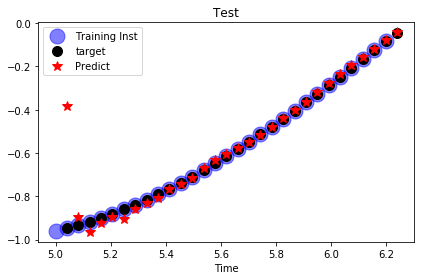

In [24]:
plt.title('Test')
# Training
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize = 15,alpha = 0.5,label = 'Training Inst')
# Target Predict
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize = 10,label = 'target')
# Model predict
plt.plot(train_inst[1:],y_pred[0,:,0],'r*',markersize = 10,label = 'Predict')

plt.xlabel('Time')
plt.legend()
plt.tight_layout()

# Genrating new Sequence

In [26]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model")
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict = {X:X_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


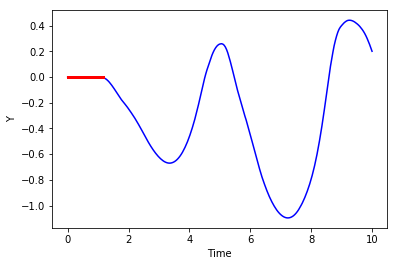

In [27]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth = 3)
plt.xlabel('Time')
plt.ylabel('Y')

In [29]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model")
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict = {X:X_batch})
        
        training_instance.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


In [ ]:
plt.plot(ts_data.x_data,zero_seq_seed,'b-')
plt.plot(ts_data.x_data[:num_time_steps],zero_seq_seed[:num_time_steps],'r',linewidth = 3)
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()